# Embedded Image Processing 
## Image Signal Processor (ISP)

### Background
An ISP is a processing block that converts raw sensor images into a colour array. There is a surprising amount of image processing that occurs between image capture and output colour images. In this task, I will implement a basic ISP.

The following processing will be done:
- Read in the image
- Demosaic (convert raw to RGB)
- Apply Colour Correction Matrix (matrix will be provided)
- Apply Denoise (e.g. bilateral filter)
- Apply Edge Enhancement (e.g. unsharp mask)
- Apply Contrast Enhancement (e.g. CLAHE)
- Save result to an output file

# Submission details:
#### Name: Ankit Juneja

In [1]:
# Useful libraries
%matplotlib inline
import os
import os.path as op

import numpy as np
import cv2
from skimage import exposure
from scipy import ndimage
import matplotlib.pylab as plt


## Read in the raw image file

For this assignment, a raw image file will be provided. This is an image of a photographic test target. The pixel data
is stored as unsigned integers, 8 bits per pixel. The code for reading the image will be provided.

The general process is to read in the binary information, then reshape the array into the image dimensions (in this case, 4096*2160 pixels)


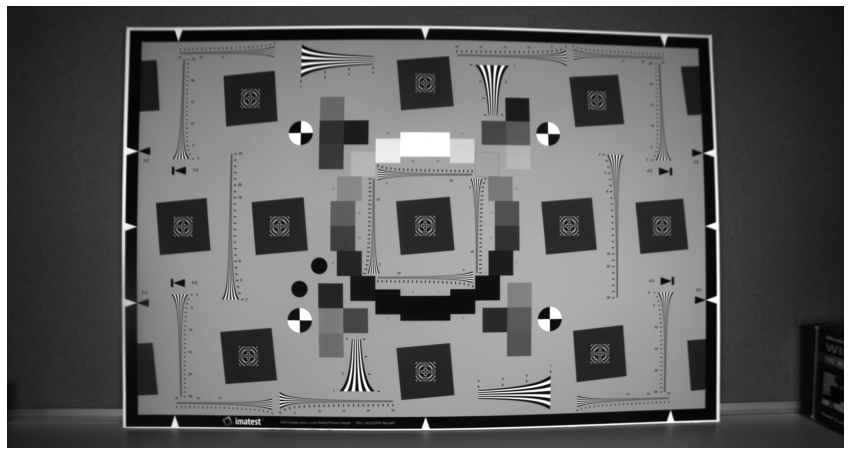

In [2]:
# Read in the file

# Raw file details:
# width - 4096
# height - 2160
# bit depth - 8
# Bayer pattern - rggb


bayer_width = 4096
bayer_height = 2160

raw_path = 'images/chart.raw'

bayer = np.fromfile(raw_path, dtype='uint8', sep='')

bayer = bayer.reshape((bayer_height, bayer_width))

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()


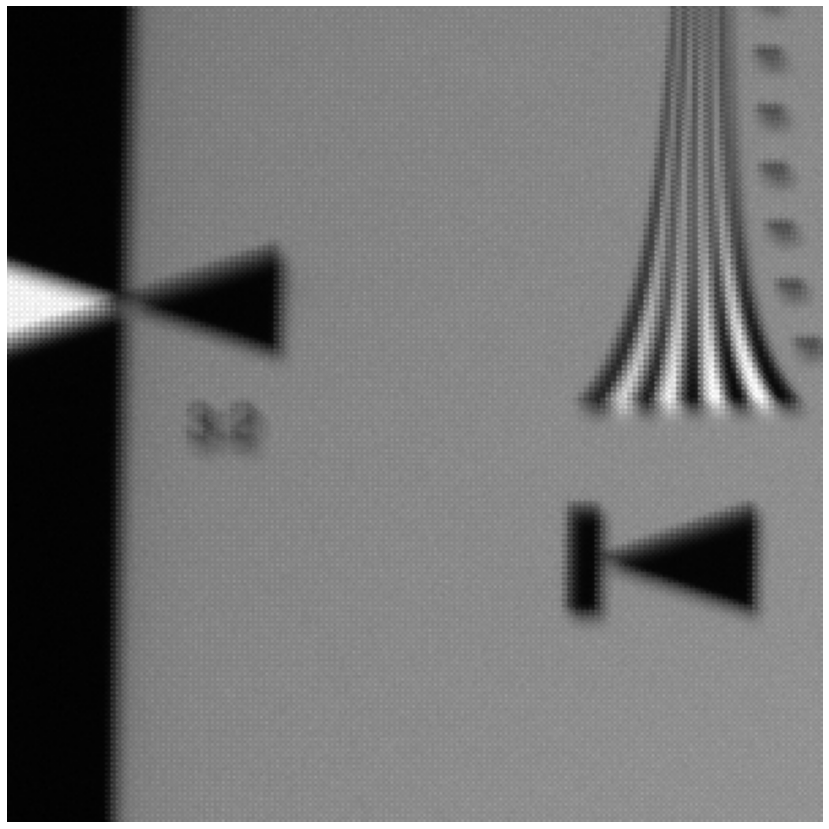

In [3]:
# crop and show a small area, to show the Bayer raw pattern

bayer_crop = bayer[600:900, 600:900] 

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(bayer_crop,cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

## Demosaic the image
The demosaic process converts raw pixel data into RGB image data. Each raw sensor pixel contains only one colour. Part of the demosaic process is to use interpolation to generate the missing colours for each pixel (i.e. a red pixel will get green and blue pixel information from the neighbouring pixels

Hint: use the opencv "cvtColor" function. This function can be used to convert between many colour spaces. For this assignment, you'll want the "COLOR_BAYER_RG2BGR" option. 

more general details are available here: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html

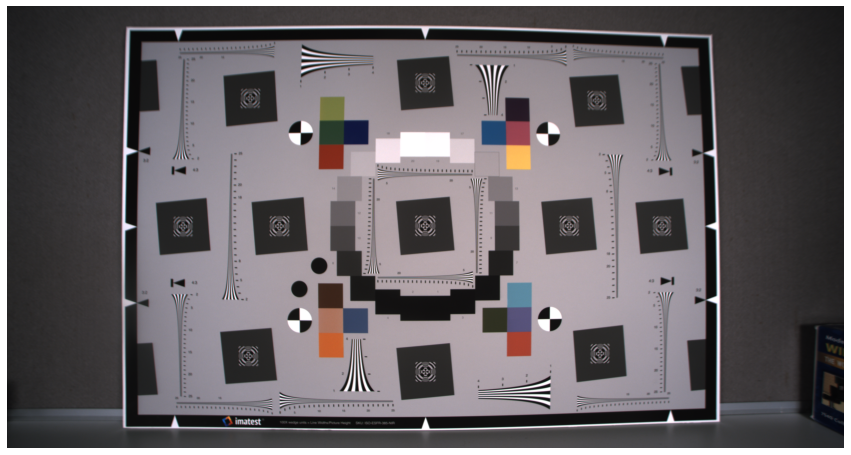

In [4]:
# Demosaic the image (i.e. covert from raw image to RGB)
rgb_image = cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(rgb_image,cmap=plt.get_cmap())
plt.axis('off')
plt.show()

## Apply colour correction

A colour correction matrix is applied to improve colour reproduction accuracy. If you notice, red appears too orange before
correction is applied.

The colour correction matrix (CCM) is calculated during the camera development phase, and varies from camera to camera.

For simplicity, the CCM for this particular camera is provided below:
    
    [[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]]
    
 
 This 3*3 matrix is multiplied by the RGB values for every pixel
 
 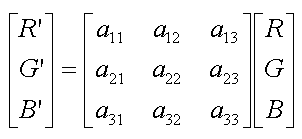
 
 
 
 Note that for embedded applications, floating point numbers are avoided wherever possible. In this example, the base is 1024 (i.e. to convert to floating point, divide the CCM by 1024)
 
 To apply the CCM in this example, the following steps are required:
 - cast the image to np.int32
 - multiply the RGB pixel data by the 3*3 CCM
 - divide by 1024
 - re-cast the image back to np.uint8
    

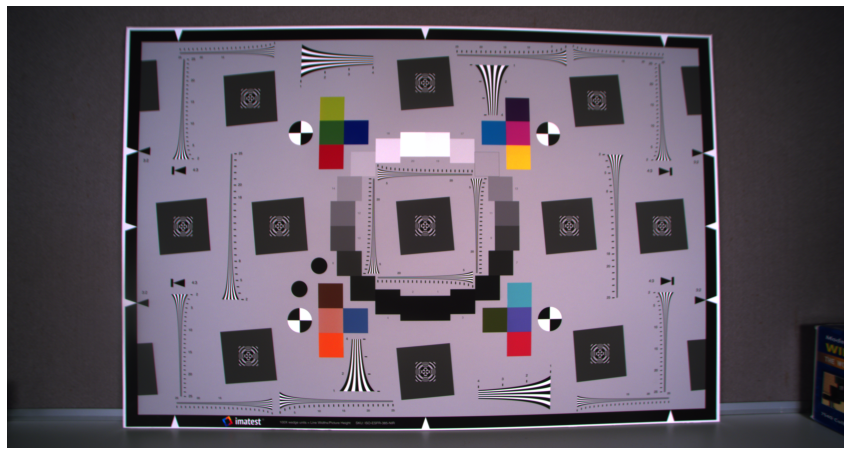

In [5]:
# apply colour correction matrix
# note: to avoid clipping, we have to temporarily cast our image data to uint16, and then return to 8 bit

# hint - cast the ccm array and image as np.int32
# multiply the image by the ccm matrix, and then use np.right_shift to scale the image down to the 8 bit range again
# use the np.clip function to ensure the data range is within 0 and 255

ccm = np.array([[ 1382, -113, -246], [ -484, 1808, -300], [ 102, -860, 1802]],dtype=np.int32).T
casted_img = np.array(rgb_image, dtype=np.int32) # cast image
cc = np.dot(casted_img, ccm) # multiply by matrix
unclip = np.divide(cc,1024) # divide by 1024
cc_img = np.clip(unclip,0,255).astype(np.uint8) # clip image and cast back to uint8

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(cc_img,cmap=plt.get_cmap())
plt.axis('off')
plt.show()

## Apply gamma correction

Gamma correction is applied using the following formula:

$$
outputImage = ((inputImage / 255)^\gamma) * 255
$$

Typically, $$\gamma=1/2.2$$


hint - use numpy clip function to ensure the data range is within 0 and 255

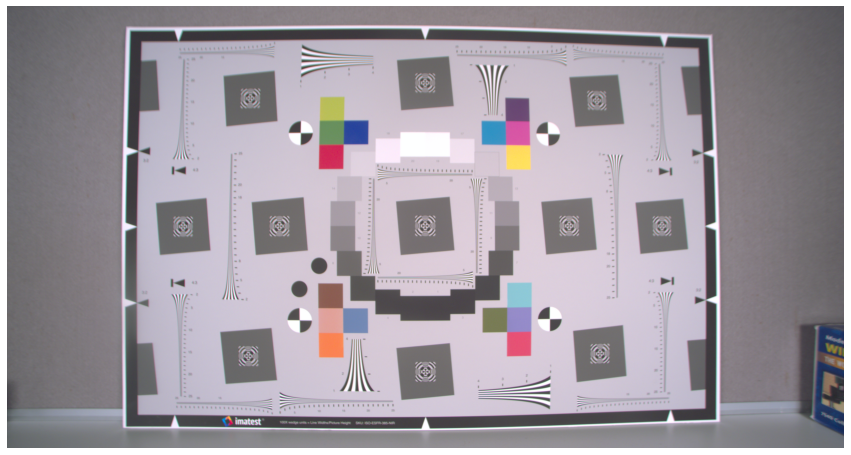

In [6]:
# apply gamma correction
gamma = 1/2.2

output_image = pow(cc_img/255, gamma)*255 # apply formula

unclipped = np.array(output_image, dtype='uint8') # cast back to uint8
gamma_corrected = np.clip(unclipped,0,255) # clip image

# plot the resulting raw file inline
plt.figure(figsize=(15,15))
plt.imshow(unclipped,cmap=plt.get_cmap())
plt.axis('off')
plt.show()

## Apply denoise to image

For this block, it is up to the student to decide which denoise block to use (there are several options available). 

One good option would be openCV's bilateral filter

Hint - experiment with parameters, examine the effect of different parameters on the image. There isn't necessarily a right or wrong configuration, but changing the parameters will have an impact on the final image

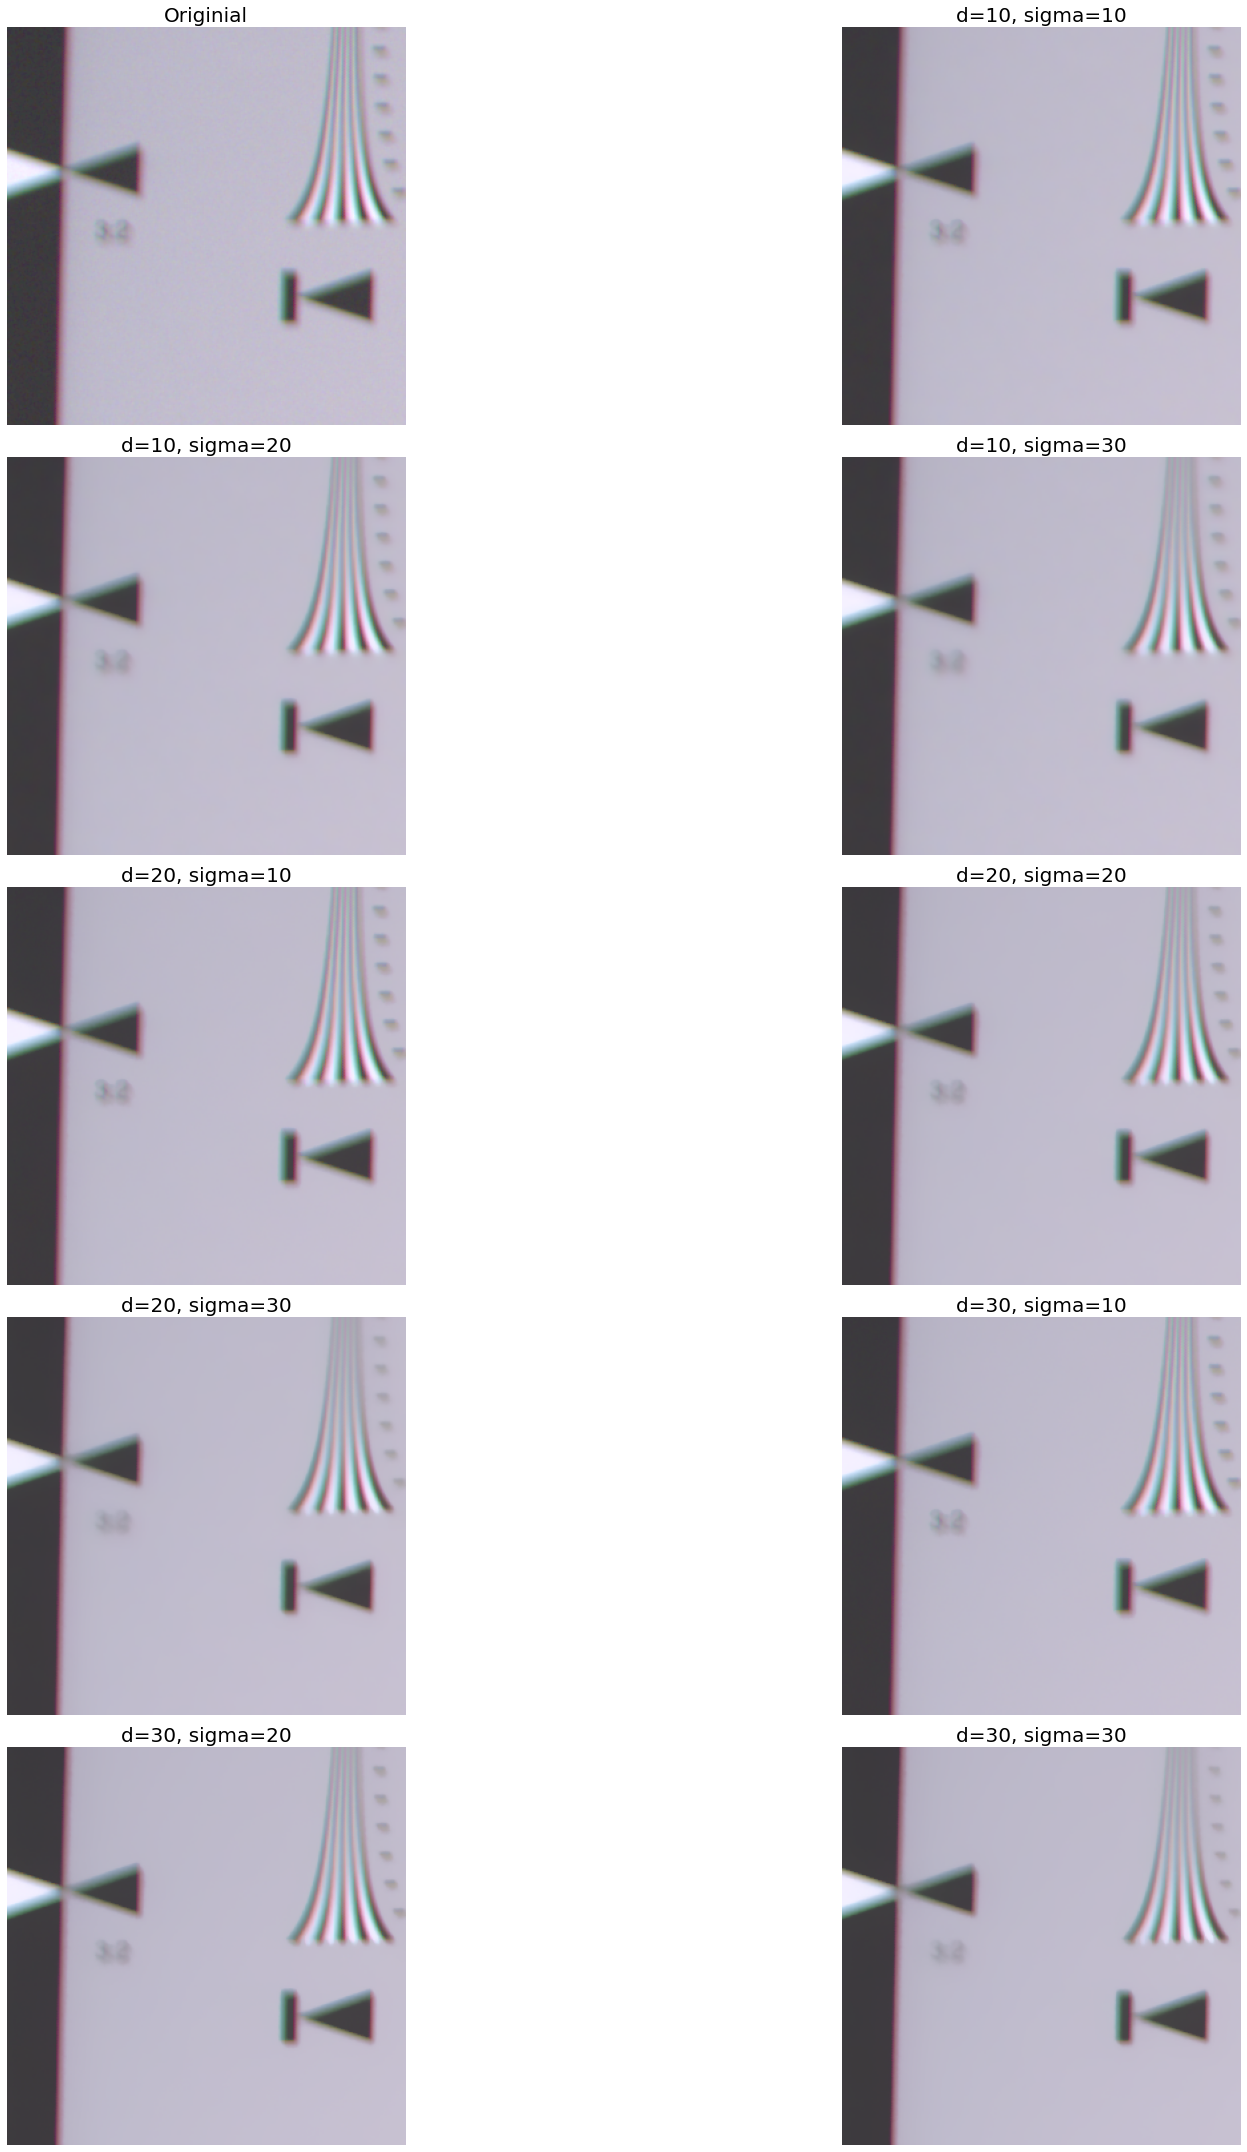

In [19]:
# apply image denoise filtering (bilateral filter)
# hint - use opencv cv2.bilateral filter

# function to plot image
def plot_image(image, title):
    plt.imshow(image,cmap=plt.get_cmap('gray')), plt.title(title, size=20), plt.axis('off')

# set parameter values
d = [10,20,30]
sigma = [10,20,30]

plt.figure(figsize=(30,30))
orig_crop = gamma_corrected[600:900, 600:900] # crop for better visualisation
plt.subplot(5,2,1), plot_image(orig_crop, 'Originial')
count=2

# experiment with filter coefficients to see the impact on the image. It might help to crop on an area to get the full effect
for i in range(0,3):
    for j in range(0,3):
        denoise_img = cv2.bilateralFilter(gamma_corrected, d[i], sigma[j], sigma[j]) # apply bilateral filter
        denoise_crop = denoise_img[600:900, 600:900] # crop image
        plt.subplot(5,2,count), plot_image(denoise_crop, 'd='+str(d[i])+', sigma='+str(sigma[j])) # plot result
        count +=1
final_denoise = denoise_img = cv2.bilateralFilter(gamma_corrected, 20, 20, 20)

plt.tight_layout()
plt.show()

The text "3.2" is still visibile with denoise for d = 20, sigma = 20. Additional denoise does not provide additional benefit. Therefore d = 20, sigma = 20 will be used to move on to next section

## Apply edge enhancement

Apply edge enhancement to the image. Again, it is up to the student to select the edge enhancement approach used (we covered a few options in class)

Again, vary the parameters and see the impact on the image

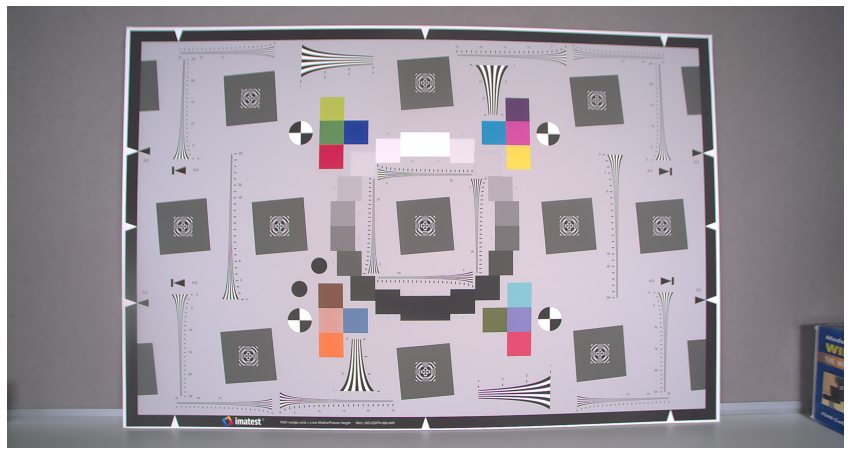

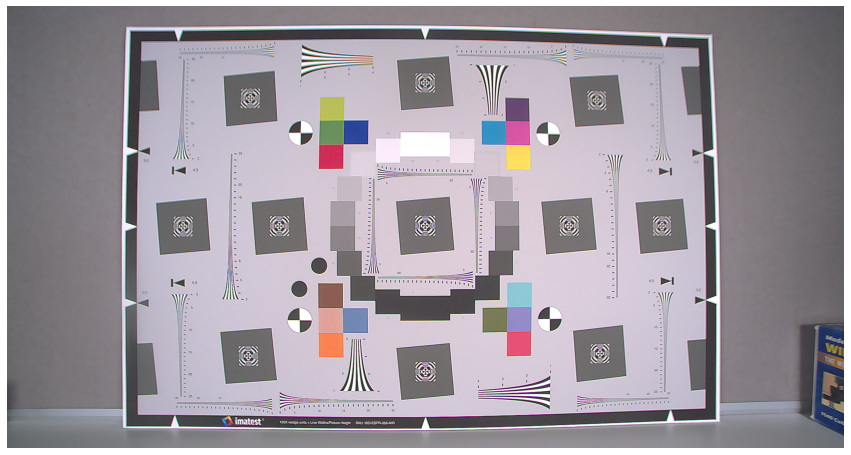

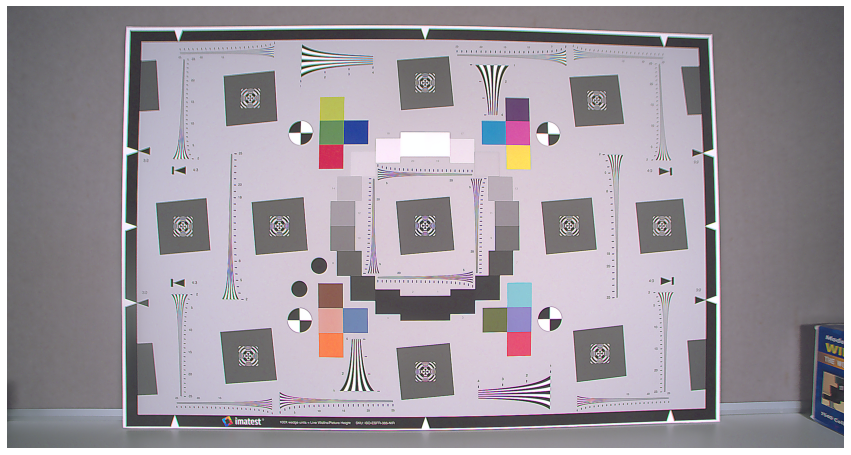

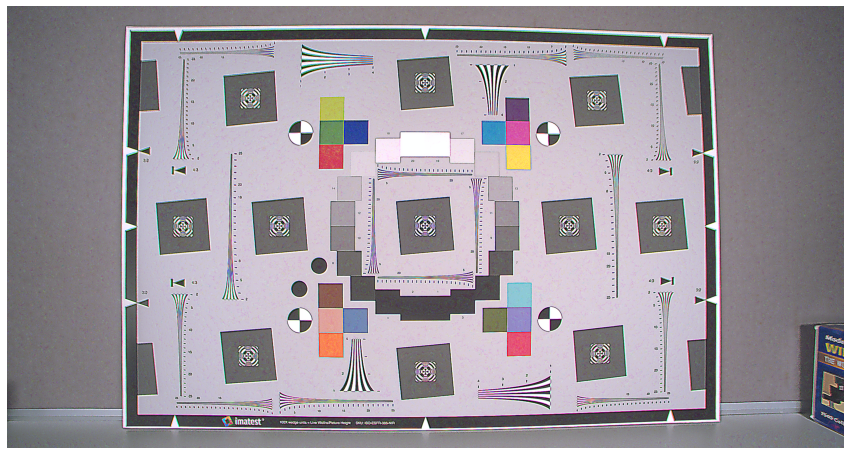

In [21]:
# apply edge enhancement
# hint: implement Laplacian or unsharp mask filtering from previous course material.
from skimage.filters import laplace
from skimage.color import rgb2hsv, hsv2rgb

kernel_size=(5, 5) 
sigma=1.0
amount=[10.0, 20.0, 30.0,100.0]
threshold=0

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

# test with different "amount" levels of sharpening. Note: other parameters can be tested in the same way...
for i in range(0,4):
    ee_img = unsharp_mask(final_denoise,kernel_size,sigma,amount[i],threshold)

    # plot the resulting raw file inline
    plt.figure(figsize=(15,15))
    plt.imshow(ee_img)
    plt.axis('off')
    plt.show()
    
ee_img_final = unsharp_mask(final_denoise,kernel_size,sigma,20,threshold)

amount = 20 gives good sharpening without over exaggerating the edges, therefore this will be used to move to next section.

## Apply contrast enhancement

Finally, apply contrast enhancement to the image. It is up to the student to select the contrast enhancement used. One option would be adaptive histogram equalization, covered earlier in the module (check out the skimage exposure library). And again, vary the parameters to examine the effect on the final image

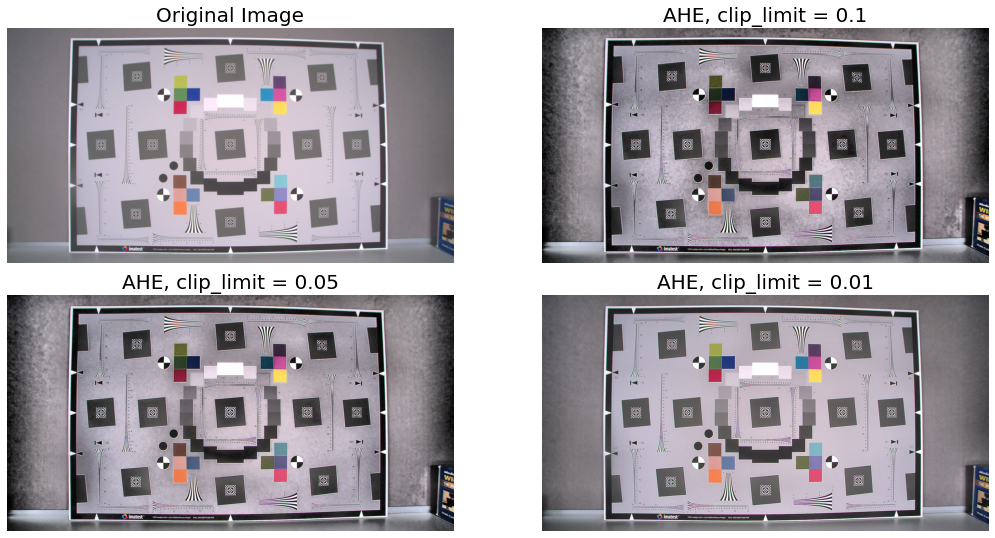

In [22]:
# increase image contrast. Hint - check out skimage exposure
from skimage.color import rgb2hsv, hsv2rgb

# set paramater values
clip = [0.1, 0.05, 0.01]

hsv_img = rgb2hsv(ee_img_final) # convert hsv
value_img = hsv_img[:,:,2] # get value channel
new_hsv = hsv_img.copy() # make copy of hsv to change during enhancement

# set up plot
plt.figure(figsize=(15,15))
plt.subplot(421), plot_image(final_denoise, 'Original Image')

# adaptive histogram equalization
for i in range(0,3):
    # apply CLAHE to value channel
    contrast_img = exposure.equalize_adapthist(value_img, clip_limit=clip[i])
    # update value channel and convert back to rgb
    new_hsv[:,:,2] = contrast_img 
    rgb_contrast = hsv2rgb(new_hsv)
    img_num=422+i
    # plot results
    plt.subplot(img_num), plot_image(rgb_contrast, 'AHE, clip_limit = ' + str(clip[i]))

plt.tight_layout()
plt.show()

A clip limit of 0.01 gives good contrast enhancement without over-emphasising the shadows which results in the backround of the board to start to look darker as with clip limits of 0.05 and 0.1

In [10]:
# save results to output file
from PIL import Image
final_result = np.array(rgb_contrast*255).astype(np.uint8)
img_array = Image.fromarray(final_result)
img_array = img_array.convert('RGB')
img_array.save('result_img.jpeg')

# read in resulting image and display
input_img = Image.open('result_img.jpeg')
input_img.show()           